## Initialization
---

In [26]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import random
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [27]:
tf.random.set_seed(42)
np.random.seed(42)
_SAMPLING_RATE = 16000

## Maestro dataset, Download and Process
---

In [30]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [31]:
search_pattern = str(data_dir / '**/*.mid*')
filenames = glob.glob(search_pattern)
print(f"Number of MIDI files found: {len(filenames)}")

Number of MIDI files found: 1282


In [32]:
sample_file = random.choice(filenames)

In [33]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [35]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=40):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [36]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


## Extract the notes from the sample MIDI file
---

In [37]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [38]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,75,1.002604,1.078125,0.000000,0.075521
1,71,1.010417,1.070312,0.007812,0.059896
2,76,1.135417,1.188802,0.125000,0.053385
3,73,1.138021,1.187500,0.002604,0.049479
4,71,1.234375,1.283854,0.096354,0.049479


In [39]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

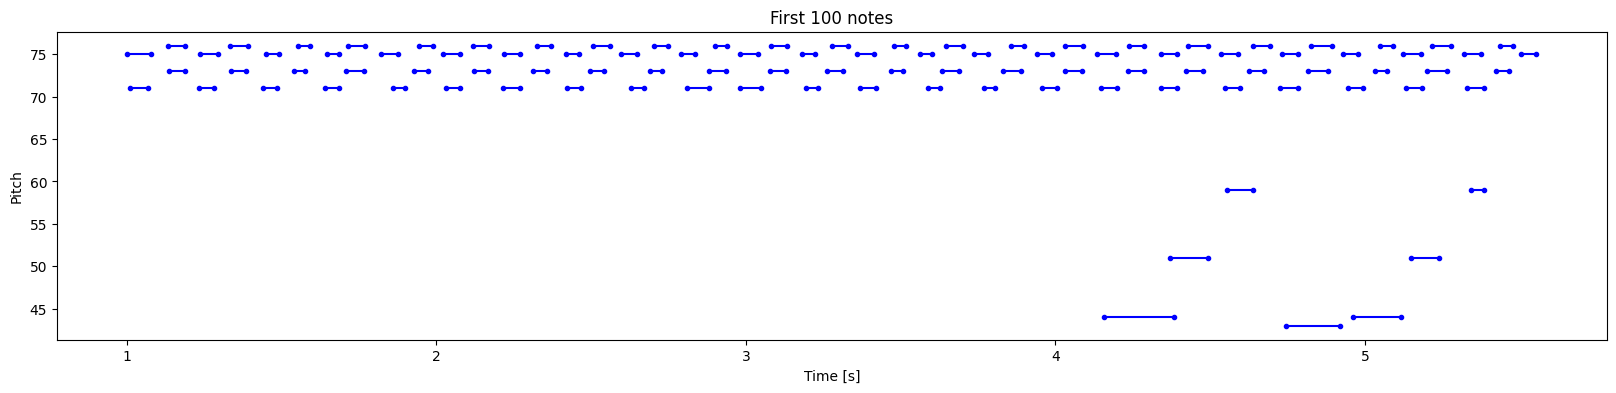

In [40]:
plot_piano_roll(raw_notes, count=100)

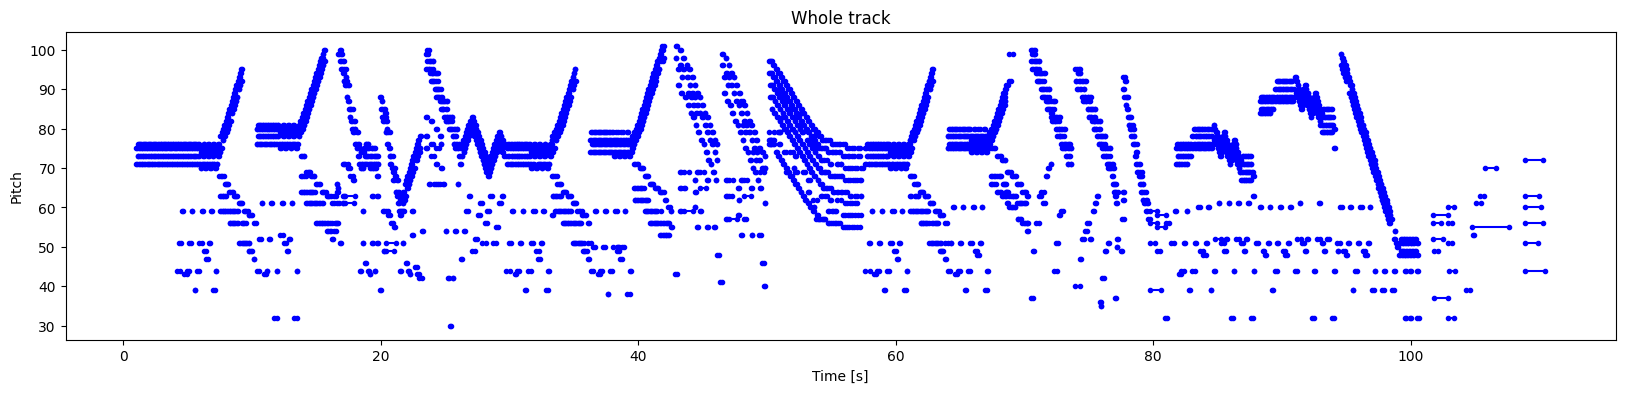

In [41]:
plot_piano_roll(raw_notes)

In [44]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


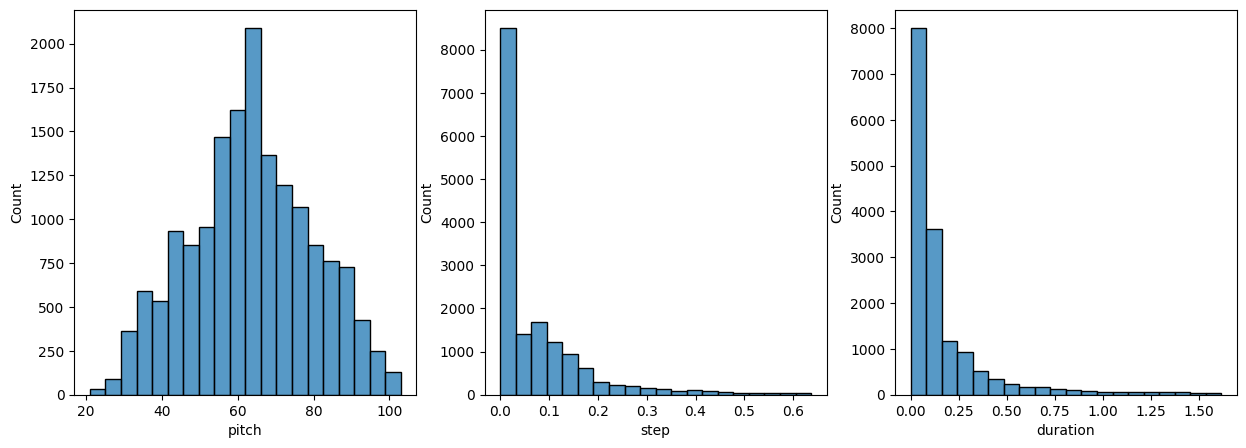

In [ ]:
plot_distributions(raw_notes)

## Training dataset
---

In [58]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [59]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 10760


In [61]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [62]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [63]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [64]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [65]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[3.75000000e-01 0.00000000e+00 1.03125000e-01]
 [2.81250000e-01 1.04166667e-03 1.66354167e+00]
 [3.75000000e-01 2.06250000e-01 9.89583333e-02]
 [4.29687500e-01 9.37500000e-02 8.54166667e-02]
 [4.68750000e-01 9.06250000e-02 8.54166667e-02]
 [5.00000000e-01 7.60416667e-02 5.31250000e-02]
 [3.75000000e-01 1.97916667e-02 1.16562500e+00]
 [4.68750000e-01 7.18750000e-02 8.95833333e-02]
 [5.23437500e-01 8.43750000e-02 7.39583333e-02]
 [5.62500000e-01 7.18750000e-02 7.29166667e-02]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=84.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0625>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.1177083333333333>}


In [66]:
batch_size = 64
buffer_size = n_notes - seq_length
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [67]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Model
---

In [68]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [69]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
losses = model.evaluate(train_ds, return_dict=True)
losses

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.1576


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 5.131400108337402}

In [71]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [72]:
model.evaluate(train_ds, return_dict=True)

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5502


{'loss': 0.5511695146560669}

In [73]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',  # Update filepath ending
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [74]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)  

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3139
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2625
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2585
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2575
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2562
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2553
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2537
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2523
Epoch 9/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2507
Epoch 10/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2505
Epoch 11/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2489
Epoch 12/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2476
Epoch 13/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2464
Epoch 14/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2450
Epoch 15/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

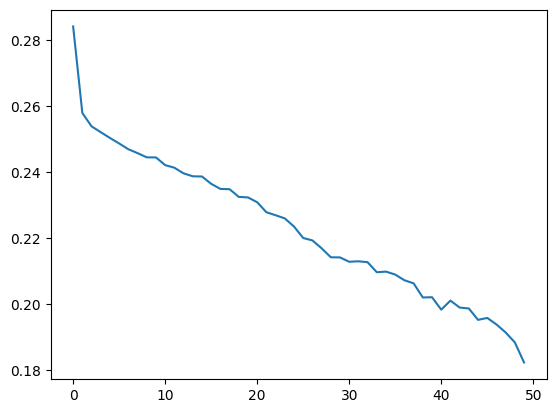

In [75]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generation
---

In [79]:
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [82]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [83]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,68,0.044733,0.051623,0.044733,0.096356
1,86,0.168236,0.385131,0.212969,0.598100
2,86,0.163203,0.438991,0.376172,0.815163
3,80,0.167096,0.445677,0.543268,0.988945
4,86,0.170027,0.439002,0.713295,1.152296
5,89,0.170151,0.440634,0.883445,1.324079
6,90,0.168622,0.440500,1.052067,1.492567
7,79,0.169888,0.443243,1.221955,1.665198
8,90,0.171066,0.434553,1.393022,1.827575
9,84,0.170068,0.438691,1.563090,2.001781


In [86]:
out_file = 'output.mid'
instrument = pm.instruments[0]
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=pretty_midi.program_to_instrument_name(instrument.program))
display_audio(out_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


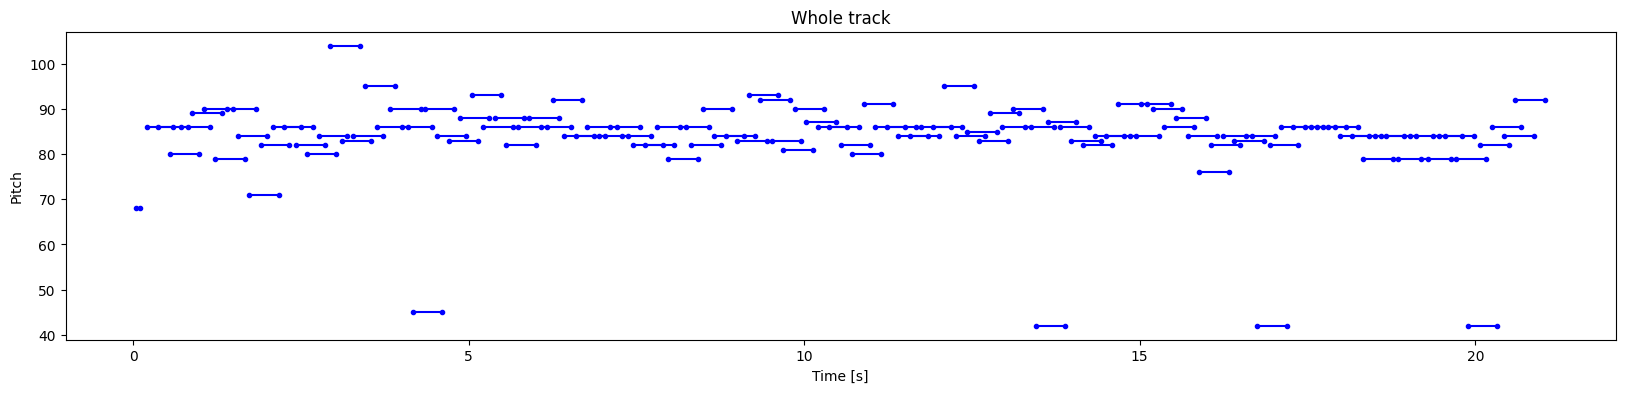

In [87]:
plot_piano_roll(generated_notes)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


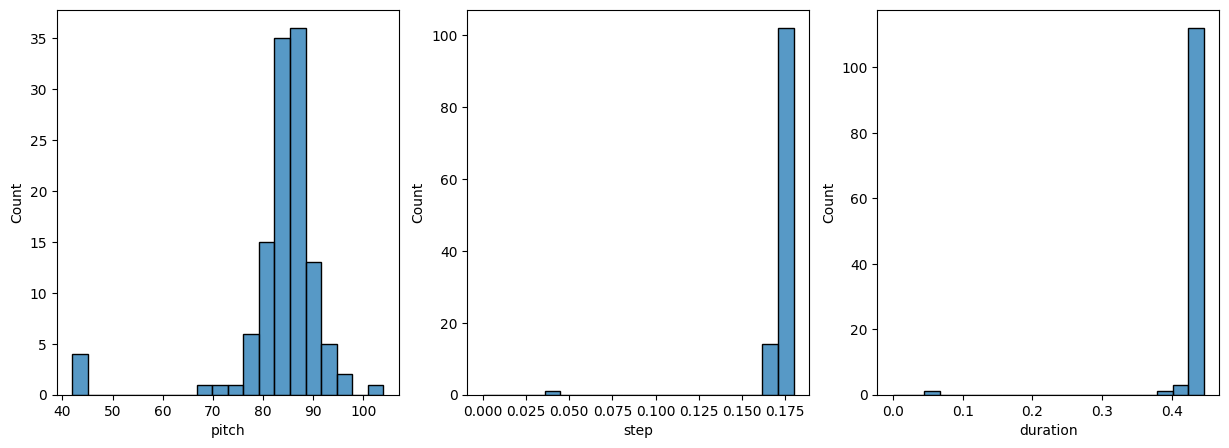

In [88]:
plot_distributions(generated_notes)